In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns

from skimage.io import imread
from skimage import img_as_float
from skimage import io, color, morphology, measure

from datetime import datetime
from tqdm.notebook import tqdm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [114]:
read_img_dir = "data/daylight_preprocessed_images"
surface_ts_path = "data/daylight_surface_ts.csv"
clean_surface_ts_path = "data/clean_daylight_surface_ts.csv"

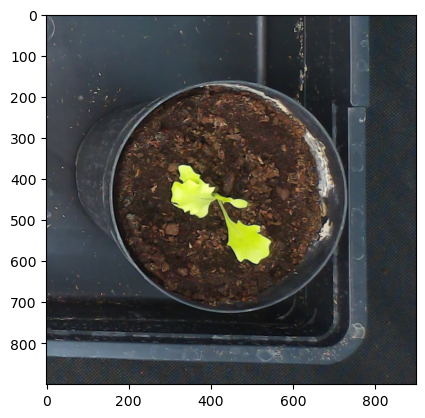

In [86]:
img = imread(f"{read_img_dir}/lettuce4_2024-07-02_15.jpg")
image = img_as_float(img)
imshow(image);

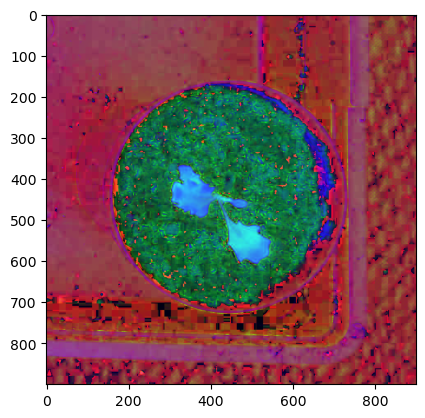

In [87]:
hsv_image = color.rgb2hsv(image)
imshow(hsv_image);

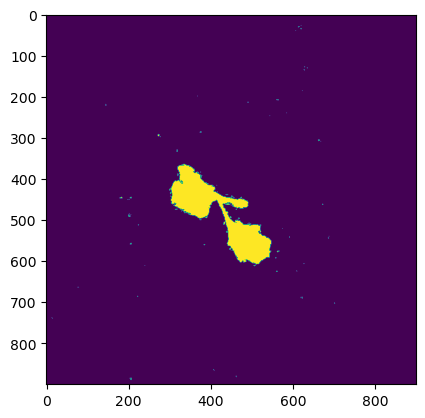

In [88]:
lower_hue = 0.15 # Green lower bound
upper_hue = 0.30 # Green upper bound
green_mask = (hsv_image[:, :, 0] >= lower_hue) & (hsv_image[:, :, 0] <= upper_hue)
green_mask &= (hsv_image[:, :, 1] >= 0.2) & (hsv_image[:, :, 1] <= 1)    # Saturation range
green_mask &= (hsv_image[:, :, 2] >= 0.2) & (hsv_image[:, :, 2] <= 1)    # Brightness range
imshow(green_mask);

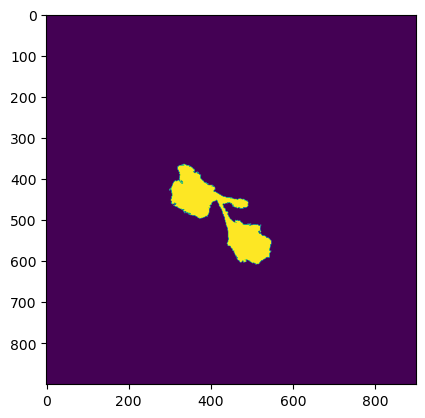

In [89]:
cleaned_mask = morphology.remove_small_objects(green_mask, min_size=500)
imshow(cleaned_mask);

In [90]:
x_cm = 20

In [91]:
# Step 3: Count the number of green pixels
green_pixels = np.sum(cleaned_mask)

# Step 4: Calculate the pixel area in cm²
total_pixels = image.shape[0] * image.shape[1]  # Total pixels in the image
pixel_area_cm2 = (x_cm ** 2) / total_pixels   
lettuce_surface_area_cm2 = green_pixels * pixel_area_cm2

print("Lettuce surface is %.2f cm2" % lettuce_surface_area_cm2)

Lettuce surface is 9.60 cm2


### Wrapping into function

In [93]:
def calculate_plant_surface(raw_img, image_side_cm, verbose=False):
    img = img_as_float(raw_img)
    if verbose:
        imshow(img)
        plt.show()
    hsv_image = color.rgb2hsv(img)
    if verbose:
        imshow(hsv_image)
        plt.show()
    lower_hue = 0.15 # Green lower bound
    upper_hue = 0.30 # Green upper bound
    green_mask = (hsv_image[:, :, 0] >= lower_hue) & (hsv_image[:, :, 0] <= upper_hue)
    green_mask &= (hsv_image[:, :, 1] >= 0.2) & (hsv_image[:, :, 1] <= 1)    # Saturation range
    green_mask &= (hsv_image[:, :, 2] >= 0.2) & (hsv_image[:, :, 2] <= 1)    # Brightness range
    if verbose:
        imshow(green_mask)
        plt.show()
    cleaned_mask = morphology.remove_small_objects(green_mask, min_size=500)
    if verbose:
        imshow(cleaned_mask)
        plt.show()
        
    green_pixels = np.sum(cleaned_mask)
    total_pixels = image.shape[0] * image.shape[1]
    pixel_area_cm2 = (image_side_cm ** 2) / total_pixels   
    surface = green_pixels * pixel_area_cm2
    return surface

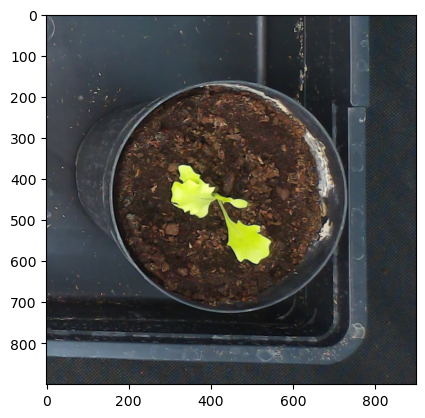

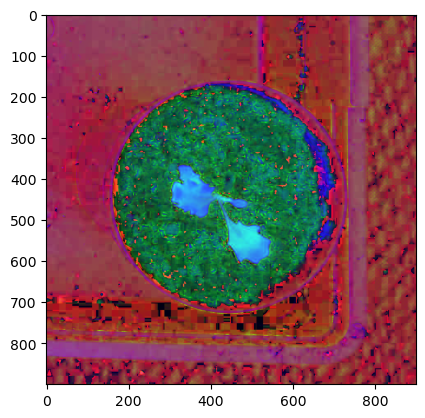

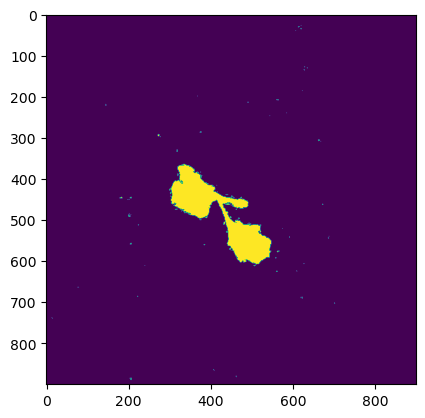

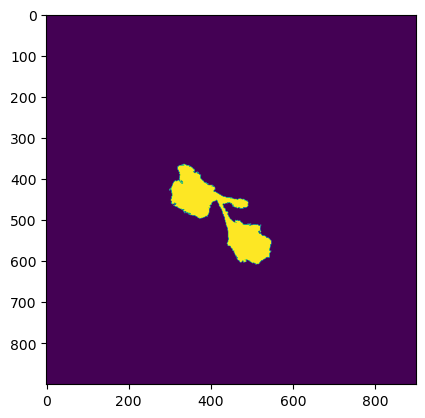

9.599506172839506

In [94]:
calculate_plant_surface(image, 20, True)

### Plant surface cm2 into Time Series

In [38]:
def process_images(directory):
    # List to store the result rows
    data = []

    # Iterate over all files in the given directory
    for filename in tqdm(os.listdir(directory)):
        if filename.endswith(".jpg"):
            # Extract the plant number and timestamp from the filename
            try:
                parts = filename.replace("lettuce", "").replace(".jpg", "").split("_")
                plant_num = int(parts[0])
                date_time_str = parts[1] + " " + parts[2]
                date_time = datetime.strptime(date_time_str, "%Y-%m-%d %H")
            except (ValueError, IndexError) as e:
                print(f"Error parsing filename: {filename}")
                continue
            
            # Read the image
            image_path = os.path.join(directory, filename)
            image = imread(image_path)
            
            # Calculate the surface
            image_side_cm = 20
            surface = calculate_plant_surface(image, image_side_cm)
            
            # Append the result to the data list
            data.append({
                "img_name": filename,
                "plant_num": plant_num,
                "date_time": date_time,
                "surface": surface
            })
    
    # Create the DataFrame
    df = pd.DataFrame(data)
    
    return df

In [39]:
surface_ts = process_images(read_img_dir)

  0%|          | 0/5504 [00:00<?, ?it/s]

In [40]:
surface_ts.sort_values(["plant_num", "date_time"]).to_csv(surface_ts_path, index=False)

### Analyze the Time Series

In [56]:
df = pd.read_csv(surface_ts_path)
df["date_time"] = pd.to_datetime(df["date_time"])
df["plant_num"] = df["plant_num"].astype(str)
df.head()

,img_name,plant_num,date_time,surface
0,lettuce1_2024-06-15_07.jpg,1,2024-06-15 07:00:00,0.0
1,lettuce1_2024-06-15_08.jpg,1,2024-06-15 08:00:00,0.0
2,lettuce1_2024-06-15_09.jpg,1,2024-06-15 09:00:00,0.0
3,lettuce1_2024-06-15_10.jpg,1,2024-06-15 10:00:00,0.0
4,lettuce1_2024-06-15_11.jpg,1,2024-06-15 11:00:00,0.0


In [65]:
# Adjusting the image dimensions decrease after "2024-07-04 15:00:00"
breakpoint = datetime(year=2024, month=7, day=4, hour=15)
coef = 20**2 / (20 * 700 / 900)**2

df["surface"] = df.apply(lambda x: x["surface"] * coef if x["date_time"] > breakpoint else x["surface"], axis=1)

In [115]:
# df.to_csv(clean_surface_ts_path, index=False)

In [67]:
def plot_ts(x, y, df, hue=None):
    fig = plt.figure(figsize=(12, 6))

    if hue:
        sns.lineplot(x=x, y=y, data=df, hue=hue)
    else:
        sns.lineplot(x=x, y=y, data=df)
    plt.xlabel('Date Time')
    plt.ylabel('Leaf Count')
    plt.title('Plant surface cm2 over time')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()

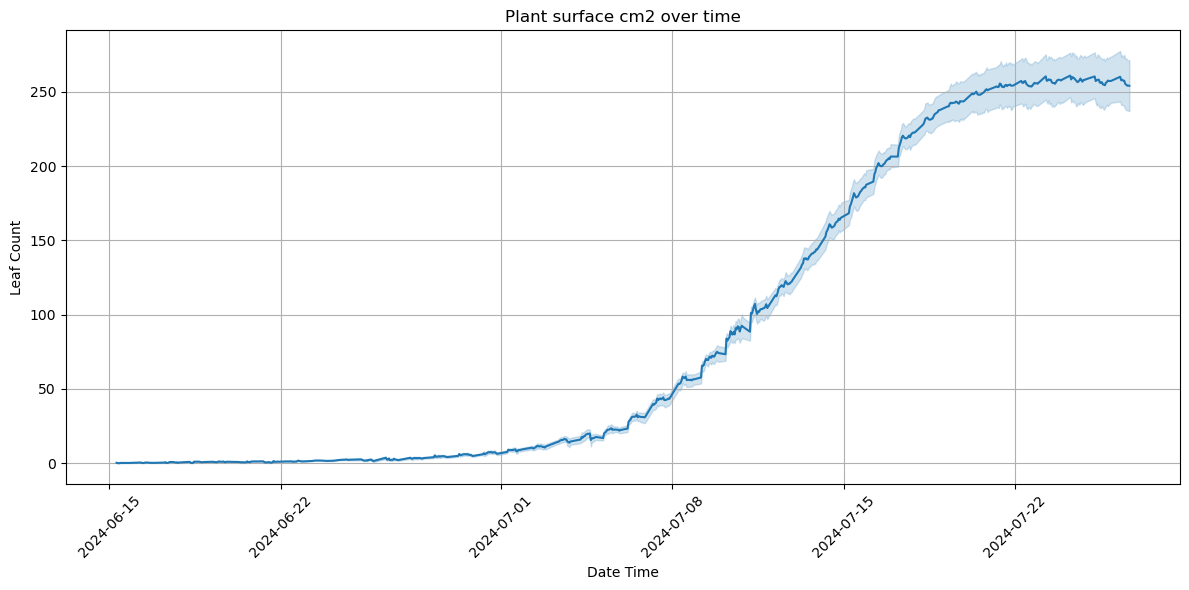

In [68]:
plot_ts(x="date_time", y="surface", df=df)

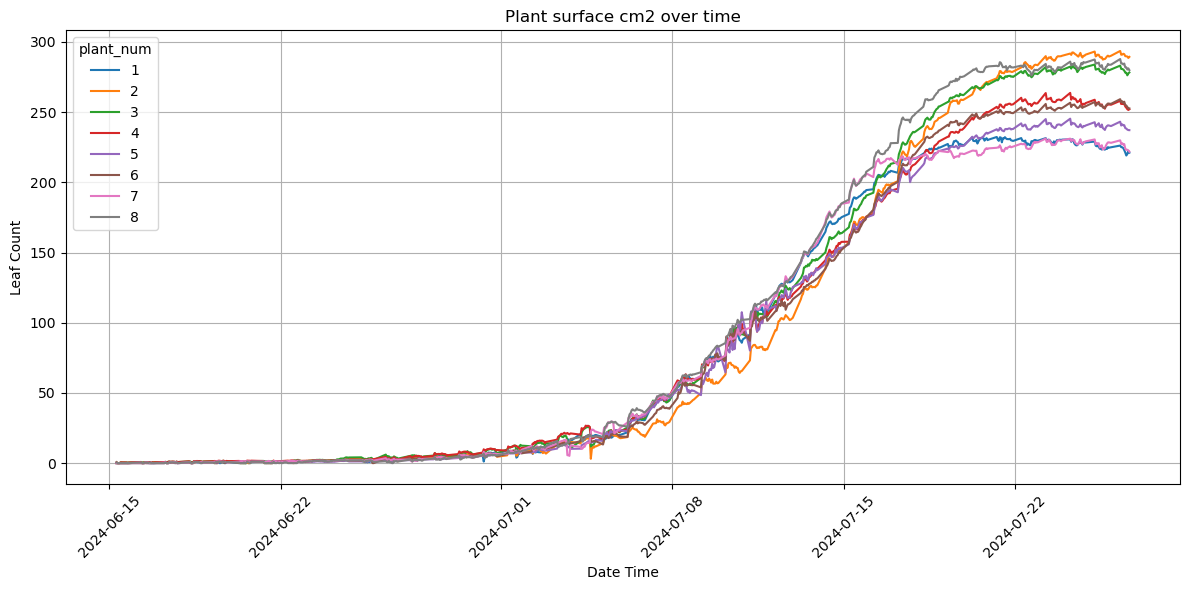

In [69]:
plot_ts(x="date_time", y="surface", df=df, hue="plant_num")

In [106]:
# Weigths from experiment
weights = {
    "1": 34,
    "2": 51,
    "3": 54,
    "4": 51, 
    "5": 40,
    "6": 52,
    "7": 31,
    "8": 44
}

Final weight per pixel calculation

In [108]:
final_plant_surface = []
weight_per_pixel = []
for i in range(1, 9):
    i = str(i)
    surf = df[df["plant_num"] == i].sort_values("date_time", ascending=False).iloc[0]["surface"]
    final_plant_surface.append(surf)
    weight_per_pixel.append(weights[i] / surf)

In [113]:
sorted(weight_per_pixel)

[0.1397389891736875,
 0.1537465615417913,
 0.1571707526837184,
 0.16864357535056054,
 0.1762403926382233,
 0.19404654530877727,
 0.202329428018965,
 0.20581186923834904]